### Add back 0.80 and 0.85 from the outcomes csv

In [1]:
quantiles = [0.50, 0.75, 0.9, 0.95]
# quantiles = [0.50, 0.75, 0.80, 0.85, 0.9, 0.95]


In [52]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')


In [3]:
gefs = pd.read_csv('results/benchmark_matrix_precip_apples.csv', index_col=0, parse_dates=True)


In [5]:
def create_con_matrix_vs_benchmark(key):
    rname = 'results/classifier_outcomes_%s.csv' % key
    outcomes = pd.read_csv(rname, index_col=0, parse_dates=True)
    binary_outcomes = outcomes.copy()
    for col in outcomes.columns[1:]:
        if outcomes[col].dtypes == 'float64':
            binary_outcomes[col] = (outcomes[col]> 0.5)


    con_precip_vs = pd.DataFrame(gefs['ERA5']) #'ERA5'

    for q in quantiles:
        for l in leads:
            label = gefs['ERA5_%0.2f' % q] #'ERA5'
            bm_pred =  gefs['GEFS_%d_%0.2f' % (l, q)]
            m_pred = pred =  binary_outcomes['CNN_%d_%0.2f' % (l, q)] # this draws from stored variable - binary_outcomes 
            con_precip_vs['VS_%d_%0.2f_PPN' % (l, q)] = (label&m_pred&~bm_pred) # corrected wrong bm_pred
            con_precip_vs['VS_%d_%0.2f_NNP' % (l, q)] = (~label&~m_pred&bm_pred)
            con_precip_vs['VS_%d_%0.2f_PPP' % (l, q)] = (label&m_pred&bm_pred) # good as always
            con_precip_vs['VS_%d_%0.2f_NNN' % (l, q)] = (~label&~m_pred&~bm_pred) # good as always
            con_precip_vs['VS_%d_%0.2f_NPP' % (l, q)] = (~label&m_pred&bm_pred) # unchanged bad pred
            con_precip_vs['VS_%d_%0.2f_PNN' % (l, q)] = (label&~m_pred&~bm_pred) # unchanged bad pred
            con_precip_vs['VS_%d_%0.2f_NPN' % (l, q)] = (~label&m_pred&~bm_pred) # change good bm_pred to incorrect because of FP
            con_precip_vs['VS_%d_%0.2f_PNP' % (l, q)] = (label&~m_pred&bm_pred) # changed good bm_pred to incorrect because of FN
             
    return con_precip_vs

In [6]:
key = '1d_precip_location_final1'
leads = [d for d in range(14)]
con_precip_vs = create_con_matrix_vs_benchmark(key)

In [7]:
import seaborn as sns

def aggregate_lt(lt):
    Test_df = con_precip_vs.filter(regex='_%d_' %lt)
    Test_df.sum()
    a = np.reshape(Test_df.sum().values,(-1, 8))
    df_vs_quantile = pd.DataFrame(a, index=quantiles, columns=["PPN", "NNP", "PPP", "NNN", "NPP", "PNN", "NPN", "PNP"])                                                                          
#    df_vs_quantile
    plt.rcParams['figure.figsize'] = [10, 4]
#     color_id = [6, 3, 5, 2, 8] #green #red #orange #purple #grey
#     # gray unchanged correct prediction
#     # green changed to correct prediction 
#     # red changed to incorrect prediction because of FN
#     # purple stayed as incorrect prediction
#     # orange changed to incorrect prediction because of FP
#     qualitative_colors = sns.color_palette("Set3", 9)
#     qualitative_colors = [qualitative_colors[i] for i in color_id]
    df_vs_quantile = df_vs_quantile.divide(df_vs_quantile.sum(axis=1), axis=0)*100

    df_vs_quantile.plot.area(color=diverging_colors, title="Percentage of classfication results of lead time=%d days" %(lt+1))
    plt.xticks(df_vs_quantile.index)

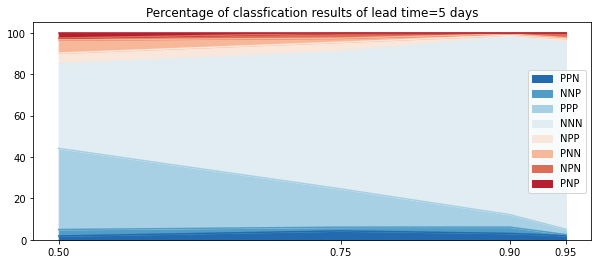

In [39]:
aggregate_lt(4)
# plt.savefig('/final_figures/7_1.svg', format='svg', dpi=1200)
# plt.savefig('/final_figures/7_1.png')
# plt.show()

In [ ]:
aggregate_lt(4)
# plt.savefig('/final_figures/7_1.svg', format='svg', dpi=1200)
# plt.savefig('/final_figures/7_1.png')
# plt.show()

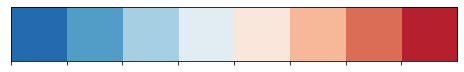

In [8]:
# find colors

diverging_colors = sns.color_palette("coolwarm", 8)

# diverging_colors =  sns.diverging_palette(220, 20, n=8)
# sns.palplot(sns.diverging_palette(220, 20, n=8))

# sns.palplot(diverging_colors)

# PPN NNP PPP NNN NPP PNN NPN PNP
diverging_colors = sns.color_palette("RdBu_r", 8)
sns.palplot(diverging_colors)
#sns.palplot(sns.diverging_palette(220, 20, n=8))


In [70]:
plt.rcParams['figure.figsize'] = [8, 3]

def fig7(lt1, lt2):
    
#    fig, axes = plt.subplots(1, 2)    
    ax1 = plt.subplot(1,2,1)

    Test_df = con_precip_vs.filter(regex='_%d_' %lt1)
    Test_df.sum()
    a = np.reshape(Test_df.sum().values,(-1, 8))
    df_vs_quantile = pd.DataFrame(a, index=quantiles, columns=["PPN", "NNP", "PPP", "NNN", "NPP", "PNN", "NPN", "PNP"])                                                                          
    df_vs_quantile = df_vs_quantile.divide(df_vs_quantile.sum(axis=1), axis=0)*100
    df_vs_quantile.plot.area(ax=ax1, 
                             color=diverging_colors, 
                            legend=False)
    plt.xlabel('quantiles \n (a)',fontsize=8)
    ax1.set_ylabel('percentage',fontsize=8)
    #ax1.yaxis.set_label_coords(-.1, .1)


    plt.xticks(df_vs_quantile.index, fontsize=8)
    plt.yticks(fontsize=8)
    #plt.title('(A)', fontsize=9, y=-0.2, pad=0)
    plt.title("Percentage of classfication results of lead time=%d days" %(lt1+1), fontsize=9)
    ax2 = plt.subplot(1,2,2)

    Test_df = con_precip_vs.filter(regex='_%d_' %lt2)
    Test_df.sum()
    a = np.reshape(Test_df.sum().values,(-1, 8))
    df_vs_quantile = pd.DataFrame(a, index=quantiles, columns=["PPN", "NNP", "PPP", "NNN", "NPP", "PNN", "NPN", "PNP"])                                                                          
    df_vs_quantile = df_vs_quantile.divide(df_vs_quantile.sum(axis=1), axis=0)*100
    df_vs_quantile.plot.area(ax=ax2, 
                             color=diverging_colors, 
                             legend=False)

    ax1.legend(loc='right', bbox_to_anchor=(1,0.5), ncol=1, fontsize=8)

    plt.yticks(fontsize=8)
    plt.xlabel('quantiles \n (b)',fontsize=8)

    plt.xticks(df_vs_quantile.index, fontsize=8)
    plt.title("Percentage of classfication results of lead time=%d days" %(lt2+1), fontsize=9)
    plt.tight_layout()

    

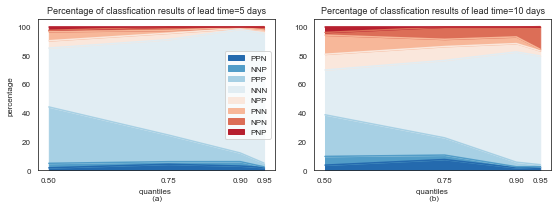

In [71]:
fig7(4,9)


plt.savefig('/final_figures/7.svg', format='svg', bbox_inches='tight')
plt.savefig('/final_figures/7.png', dpi=300, bbox_inches='tight')
plt.show()